## SARIMAX Model

### 1. Import libraries and get data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import statsmodels.api as sm

In [2]:
# Load the dataset
df = pd.read_csv("./USDT.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df

,Price
Date,
2017-12-01,1.0100
2017-12-02,0.9959
2017-12-03,0.9977
2017-12-04,1.0000
2017-12-05,1.0000
...,...
2023-03-28,1.0001
2023-03-29,0.9999
2023-03-30,1.0000


### 2. Split the data into training, test and validate sets

In [3]:
train_size = int(0.7 * len(df))
test_size = int(0.15 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1362, 1)
Test shape: (292, 1)
Validate shape: (293, 1)


In [4]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1168, 1)
Test shape: (389, 1)
Validate shape: (390, 1)


In [5]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1362, 1)
Test shape: (389, 1)
Validate shape: (196, 1)


## 3. Perform SARIMAX Model

Exogenous variable

In [6]:
train_data['seasonal_index'] = train_data.index.day

C:\Users\PHUTRAN\AppData\Local\Temp\ipykernel_23344\586218167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['seasonal_index'] = train_data.index.day


### 3.1 Build the best SARIMAX Model from auto_arima

In [7]:
# SARIMAX Model
import pmdarima as pmd

SARIMAX_model = pmd.auto_arima(train_data[['Price']], 
                        exogenous=train_data[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-11250.862, Time=5.85 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-9624.032, Time=0.76 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-11167.070, Time=6.60 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-10615.909, Time=4.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-9625.977, Time=0.14 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-10737.082, Time=3.03 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-11229.075, Time=2.39 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-11265.275, Time=16.37 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=-11239.144, Time=23.10 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-10702.796, Time=31.10 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-11435.833, Time=24.34 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-11204.118, Time=4.30 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=-11179.966, Time=32.38 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-11193.704, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 1362
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 12)   Log Likelihood                5782.699
Date:                                 Tue, 13 Jun 2023   AIC                         -11551.397
Time:                                         00:08:43   BIC                         -11514.942
Sample:                                              0   HQIC                        -11537.745
                                                - 1362                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8708      0.009    100.025      0.000       0.854       0.888
ma.L1         -0.0395      0.016     -2.467      0.014      -0.071      -0.008
ar.S.L12      -0.5357      0.554     -0.966      0.334      -1.622       0.551
ar.S.L24      -0.0407      0.163     -0.250      0.803      -0.360       0.278
ma.S.L12      -0.4939      0.558     -0.885      0.376      -1.588       0.600
ma.S.L24      -0.2136      0.417     -0.513      0.608      -1.030       0.603
sigma2      1.098e-05   1.65e-07     66.652      0.000    1.07e-05    1.13e-05
===================================================================================
Ljung-Box (L1) (Q):                   6.87   Jarque-Bera (JB):             10714.08
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.2 Evaluate on Validate data

In [8]:
def evaluate_sarimax_model(y_data):
    predictions = (SARIMAX_model.predict(n_periods=len(y_data))).values
    mse = mean_squared_error(y_data, predictions)
    mae = mean_absolute_error(y_data, predictions)
    mape = mean_absolute_percentage_error(y_data, predictions)
    rmse = mean_squared_error(y_data, predictions, squared=False)
    return predictions, mse, mae, mape, rmse

In [9]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaluate_sarimax_model(y_val)

print("Price predict on validate data:", y_pred_val)

Price predict on validate data: [1.00050559 1.00030796 1.00032323 1.00026183 1.00042078 1.00056695
 1.00039745 1.00041891 1.00038674 1.00033173 1.00043008 1.0003249
 1.00044149 1.00036418 1.00043215 1.0002796  1.00036287 1.00049789
 1.00034718 1.00042494 1.00044881 1.00041111 1.00039495 1.00031263
 1.00046604 1.00034064 1.00038805 1.0002707  1.00038409 1.00052331
 1.00036546 1.0004204  1.00042377 1.00037909 1.00040812 1.00031788
 1.00045523 1.00035073 1.00040704 1.00027456 1.00037493 1.00051237
 1.00035759 1.00042248 1.00043457 1.00039294 1.00040242 1.00031551
 1.00045997 1.00034624 1.00039862 1.00027282 1.00037894 1.00051717
 1.00036104 1.00042153 1.00042978 1.00038681 1.00040492 1.00031655
 1.00045786 1.00034822 1.00040235 1.00027359 1.00037716 1.00051504
 1.00035951 1.00042195 1.0004319  1.00038952 1.00040381 1.00031609
 1.00045879 1.00034734 1.0004007  1.00027325 1.00037795 1.00051598
 1.00036019 1.00042177 1.00043096 1.00038832 1.00040431 1.00031629
 1.00045838 1.00034773 1.000401

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 3.3 Evaluate on Test data

In [10]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaluate_sarimax_model(y_test)

print("Price predict on test data:", y_pred_test)

Price predict on test data: [1.00050559 1.00030796 1.00032323 1.00026183 1.00042078 1.00056695
 1.00039745 1.00041891 1.00038674 1.00033173 1.00043008 1.0003249
 1.00044149 1.00036418 1.00043215 1.0002796  1.00036287 1.00049789
 1.00034718 1.00042494 1.00044881 1.00041111 1.00039495 1.00031263
 1.00046604 1.00034064 1.00038805 1.0002707  1.00038409 1.00052331
 1.00036546 1.0004204  1.00042377 1.00037909 1.00040812 1.00031788
 1.00045523 1.00035073 1.00040704 1.00027456 1.00037493 1.00051237
 1.00035759 1.00042248 1.00043457 1.00039294 1.00040242 1.00031551
 1.00045997 1.00034624 1.00039862 1.00027282 1.00037894 1.00051717
 1.00036104 1.00042153 1.00042978 1.00038681 1.00040492 1.00031655
 1.00045786 1.00034822 1.00040235 1.00027359 1.00037716 1.00051504
 1.00035951 1.00042195 1.0004319  1.00038952 1.00040381 1.00031609
 1.00045879 1.00034734 1.0004007  1.00027325 1.00037795 1.00051598
 1.00036019 1.00042177 1.00043096 1.00038832 1.00040431 1.00031629
 1.00045838 1.00034773 1.00040143 1

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 3.4 Predict price for the next 30 days

In [11]:
last_index = len(df)
date_range = pd.date_range(start=df.index[-1], periods=30, freq='D')

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = (SARIMAX_model.predict(n_periods=len(x_next_30_days))).values

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1.00050559 1.00030796 1.00032323 1.00026183 1.00042078 1.00056695
 1.00039745 1.00041891 1.00038674 1.00033173 1.00043008 1.0003249
 1.00044149 1.00036418 1.00043215 1.0002796  1.00036287 1.00049789
 1.00034718 1.00042494 1.00044881 1.00041111 1.00039495 1.00031263
 1.00046604 1.00034064 1.00038805 1.0002707  1.00038409 1.00052331]


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 4.  Evaluate accuracy validate, test data

In [12]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

df = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(df)


                   MSE       MAE      MAPE      RMSE
Validate  1.006635e-06  0.000580  0.000579  0.001003
Test      3.471282e-07  0.000404  0.000404  0.000589


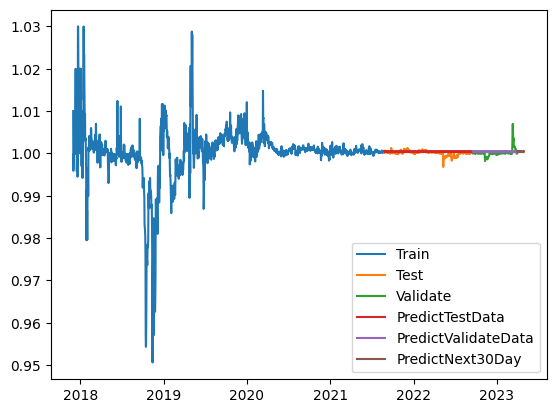

In [13]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])

plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(date_range, y_next_30_days)

plt.legend(['Train', 'Test', 'Validate','PredictTestData', 'PredictValidateData','PredictNext30Day'])
plt.show()